<a href="https://colab.research.google.com/github/maggiedart16/Earth-and-Environmental-Systems-Modeling/blob/main/mod03_1D_Diffusion_Assignment_ipynb_txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 03: Assignment for 1-D Diffusion Problem - Thawing Permafrost

### 1. Introduction and Background

In this notebook you are going to investigate the impact of three climate change scenarios on our previously developed model of the vertical distribution of temperature in a permafrost soil.


Again, the equation for 1-dimensional heat diffusion into a soil is presented below:
$$
\rho_s \cdot C_s \cdot \frac{\partial T_s}{\partial t} = \frac{\partial T_s}{\partial z}\left(k_s \cdot \frac{\partial T_s}{\partial z}\right)
$$

where $\rho_s$ (kg/m^3) is the bulk density of the soil, $C_s$ (J/(kg K)) is the heat capacity of the soil, $k_s$ (W/(m K)) is the thermal conductivity of the soil, $T_s$ is the temperature of the soil at some time $t$ and depth in the soil $z$. For the sake of simplicity, we're going to assume that the thermal conductivity is constant. This assumption is not strictly true, as $k_s$ changes with the amount and phase (frozen or liquid) of water in the soil. But it makes the math much simpler and is good starting point for a toy model. Under this assumption we can simplify the above equation to,

$$
\rho_s \cdot C_s \cdot \frac{\partial T_s}{\partial t} = k_s \frac{\partial T_s^2}{\partial^2 z}
$$

Going further, if we also assume that the bulk density ($rho_s$) and heat capacity ($C_s$) are constant, then we can combine them with the thermal conductivity and reduce them to a single parameter that is often referred to as the _thermal diffusivity_ ($D_s$) and has dimensions of m^2/s,

$$
D_s = \frac{k_s}{\rho_s \cdot C_s}
$$

Substituting into the above, we obtain the following governing equation that our model will solve,

$$
\frac{\partial T_s}{\partial t} = D_s \frac{\partial T_s^2}{\partial^2 z}
$$

Your __top boundary condition__, we will assume sinusoidal forcing of air temperature superimposed on a linear trend in mean annual temperatures at the surface, with a period of one year. In this notebook we will explore three scenarios. Scenario 1 is a linear increase in mean annual temperature at a rate that results in 1.5 °C of warming by 2100. Scenario 2 is a linear increase in mean annual temperature at a rate that results in 3.0 °C of warming by 2100. Scenario 3 is a linear increase in mean annual temperature at a rate that results in 4.5 °C of warming by 2100. We will start all simulations in 2020.

Your __bottom boundary condition__, we will assume a constant temperature at the initial mean annual air temperature.

Yur __initial condition__ will be a constant temperature (isothermal) at the mean annual air temperature. If interested you can copy this notebook and modify these values.

### 2. Initial Setup

Below, we set the values for our spatial domain, simulation period, soil properties, and boundary conditions.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Soil column properties
zs = 500.0 # Depth of soil [cm]
dz = 15.0   # Numerical model layer thickness [cm]

# Soil properties (obtained from https://doi.org/10.1029/2017JF004535)
Cs = 635.0 # Heat capacity of soil/permafrost [J/(kg K)]
ks = 0.25  # Thermal conductivity of soil/permafrost [W/(m K)]
rhos = 920.0 # Bulk density of permafrost [kg/m^3]

dt = 0.25 # Time step [day]

#### 2.1 Load and Plot the Air Temperature Trends

In [4]:
from google.colab import files
uploaded = files.upload()

Saving PermafrostTemperatureScenarios.csv to PermafrostTemperatureScenarios.csv


In [5]:
data = np.loadtxt('PermafrostTemperatureScenarios.csv', delimiter=',', skiprows=1)

t_year = data[:,0]
T_15 = data[:,1]
T_30 = data[:,2]
T_45 = data[:,3]

Text(0, 0.5, 'Annual average air temperature [°C]')

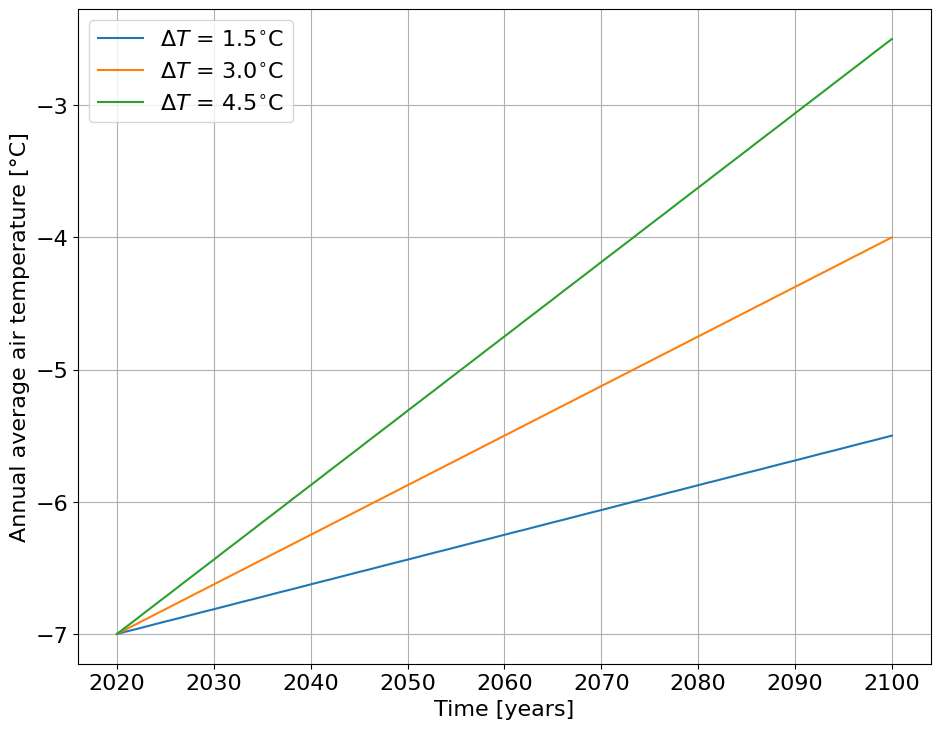

In [6]:
## First off, let's change the font size for all of our plots to be more legible
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(11.0,8.5))
plt.plot(t_year,T_15,label='$\Delta T$ = 1.5${}^{\circ}$C')
plt.plot(t_year,T_30,label='$\Delta T$ = 3.0${}^{\circ}$C')
plt.plot(t_year,T_45,label='$\Delta T$ = 4.5${}^{\circ}$C')
plt.legend(loc='upper left')
plt.grid()
plt.xlabel('Time [years]')
plt.ylabel('Annual average air temperature [°C]')

#### 2.2 Setup the Simulation Time Period

In [7]:
# Time properties of simulation
t0 = t_year[0]
tf = t_year[-1]

t = np.arange(t0,tf+(dt/365),(dt/365))
Nt = t.size
print('The number of time steps: Nt = ',str(Nt))

The number of time steps: Nt =  116801


### 3. Setup Boundary Conditions

In [8]:
# Boundary conditions
Ttopamp = 35.0
Tbottom = -7.0

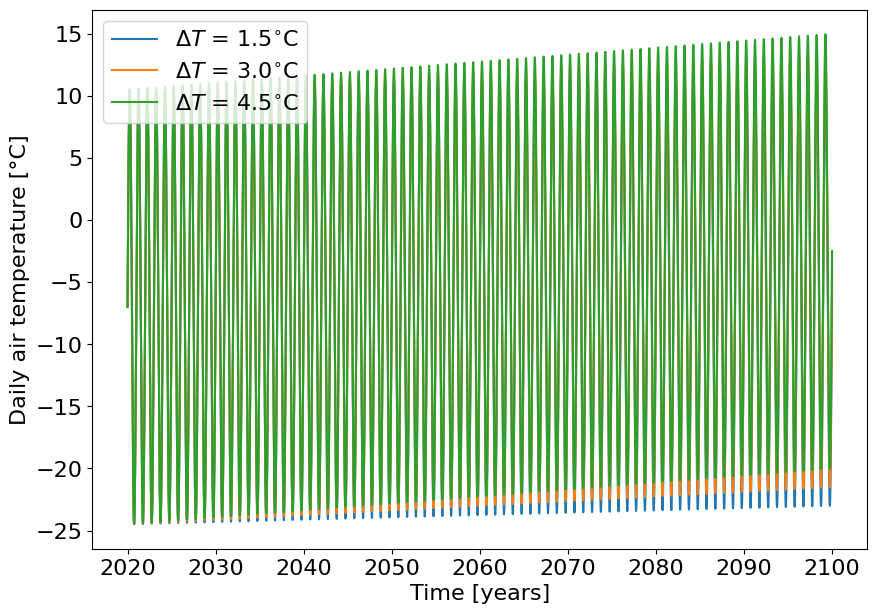

In [9]:
Ttop_15 = np.interp(t, t_year, T_15) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)
Ttop_30 = np.interp(t, t_year, T_30) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)
Ttop_45 = np.interp(t, t_year, T_45) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)

plt.figure(figsize=(10.0,7.0))
plt.plot(t, Ttop_15, label='$\Delta T$ = 1.5${}^{\circ}$C')
plt.plot(t, Ttop_30, label='$\Delta T$ = 3.0${}^{\circ}$C')
plt.plot(t, Ttop_45, label='$\Delta T$ = 4.5${}^{\circ}$C')
plt.xlabel('Time [years]')
plt.ylabel('Daily air temperature [°C]')
plt.legend(loc='upper left')
plt.show()

### 4. Setup Spatial Domain

In [20]:
z = np.arange(dz/2, zs, dz)
Nz = z.size


### 5. Setup Initial Condition

In [21]:
import numpy as np
T_initial = -7.0
T = np.ones(Nz) * T_initial


### 6. Calculate $D$, $\mathbf{A}$, and $\mathbf{B}$ Matrices for Implicit or Crank-Nicolson Method

In [22]:
import numpy as np

# Calculate Ds
Ds = ks / (rhos * Cs)

# Initialize matrices
A = np.zeros((Nz, Nz))
B = np.zeros((Nz, Nz))

# Create diagonal elements
for i in range(Nz):
  if i == 0: # top layer
    A[i, i] = 1.0 + (2.0 * Ds * dt / (dz * dz))
    A[i, i + 1] = -(Ds * dt / (dz * dz))
    B[i, i] = 1.0 - (2.0 * Ds * dt / (dz * dz))
    B[i, i + 1] = (Ds * dt / (dz * dz))
  elif i == Nz - 1: # bottom layer
    A[i, i] = 1.0 + (2.0 * Ds * dt / (dz * dz))
    A[i, i - 1] = -(Ds * dt / (dz * dz))
    B[i, i] = 1.0 - (2.0 * Ds * dt / (dz * dz))
    B[i, i - 1] = (Ds * dt / (dz * dz))
  else:
    A[i, i] = 1.0 + (2.0 * Ds * dt / (dz * dz))
    A[i, i + 1] = -(Ds * dt / (dz * dz))
    A[i, i - 1] = -(Ds * dt / (dz * dz))
    B[i, i] = 1.0 - (2.0 * Ds * dt / (dz * dz))
    B[i, i + 1] = (Ds * dt / (dz * dz))
    B[i, i - 1] = (Ds * dt / (dz * dz))

D = np.linalg.inv(A)



### 7. Preallocate Storage for Soil Temperatures

In [23]:
Ts = np.zeros((Nz,Nt))

### 8. Apply Solution And Compute Temperatures

In [24]:
import numpy as np
for i in range(Nt - 1):
  T_old = T

  # Apply boundary conditions
  RHS = np.dot(B, T_old)
  RHS[0] = Ttop_15[i]
  RHS[Nz - 1] = Tbottom

  # Solve for new temperature
  T = np.dot(D, RHS)

  Ts[:, i] = T
Ts[:, Nt - 1] = T


### 9. Plot Results, Analyze, and Interpret

Create plots of the following:

1. A plot of 3 x 2 subplots of the vertical temperature distribution with time. Each row should correspond to each of the 3 climate change scenarios wiht the top row being the $\Delta T$ = 1.5${}^{\circ}$C, the middle being $\Delta T$ = 3.0${}^{\circ}$C, and the bottom row being $\Delta T$ = 4.5${}^{\circ}$C. The left column should correspond to the ___first___ 10 years of simulation, and the right column the ___last___ 10 years of simulation.
2. A plot of 2 x 2 subplots of the temperature at four different levels. One subplot of temperature versus time for all three scenarios at a depth of 50 cm, the second subplot the same information at 100 cm, the third subplot the same information at 200 cm, and the fourth subplot the same information at 400 cm.
3. A markdown table showing the approximate depth of the active layer for each scenario for the first, a middle, and the final decade of the simulation.  

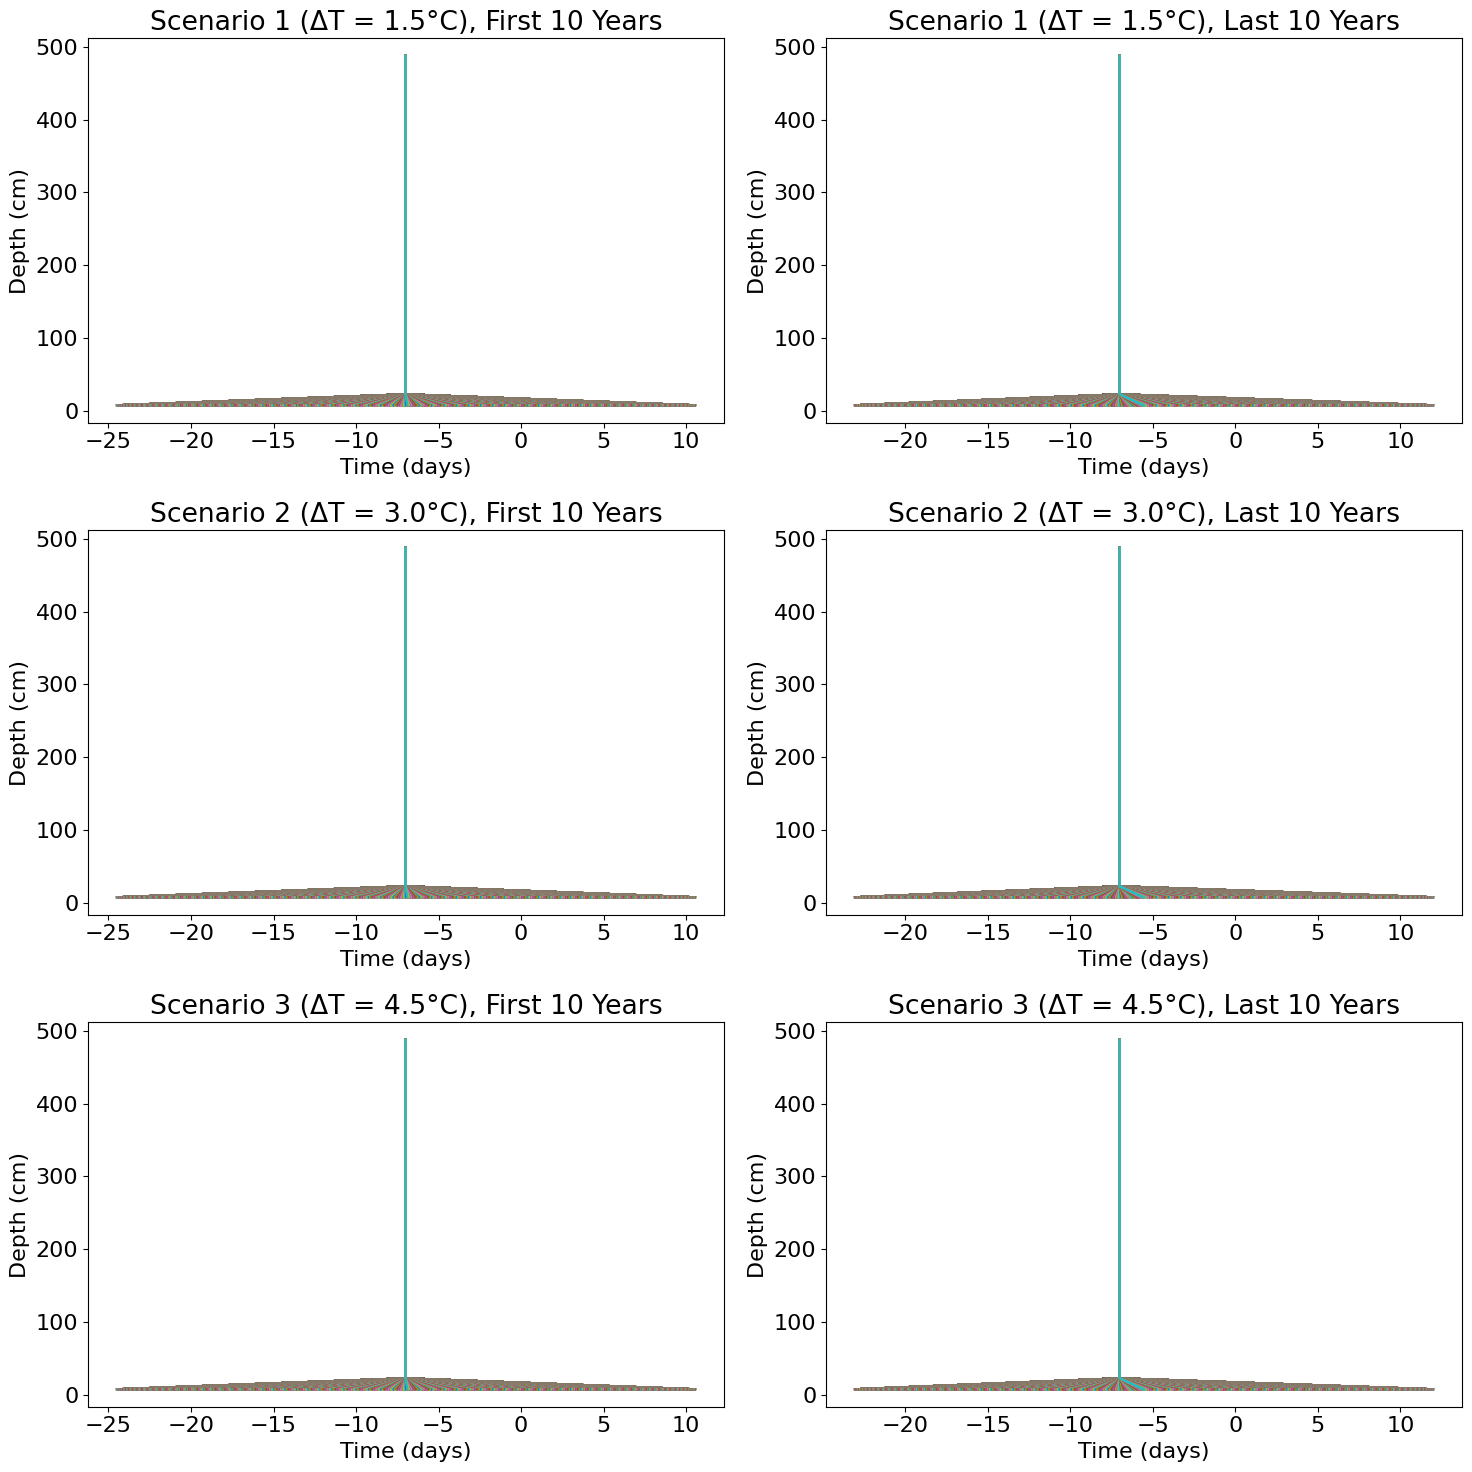

In [25]:
import matplotlib.pyplot as plt

# Create a 3x2 subplot figure
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Loop through each scenario and plot the vertical temperature distribution
for i, Ttop in enumerate([Ttop_15, Ttop_30, Ttop_45]):
    # First 10 years
    axes[i, 0].plot(Ts[:, :int(10 * 365)], z)
    axes[i, 0].set_xlabel('Time (days)')
    axes[i, 0].set_ylabel('Depth (cm)')
    axes[i, 0].set_title(f'Scenario {i + 1} (ΔT = {(i + 1) * 1.5}°C), First 10 Years')

    # Last 10 years
    axes[i, 1].plot(Ts[:, -int(10 * 365):], z)
    axes[i, 1].set_xlabel('Time (days)')
    axes[i, 1].set_ylabel('Depth (cm)')
    axes[i, 1].set_title(f'Scenario {i + 1} (ΔT = {(i + 1) * 1.5}°C), Last 10 Years')

plt.tight_layout()
plt.show()


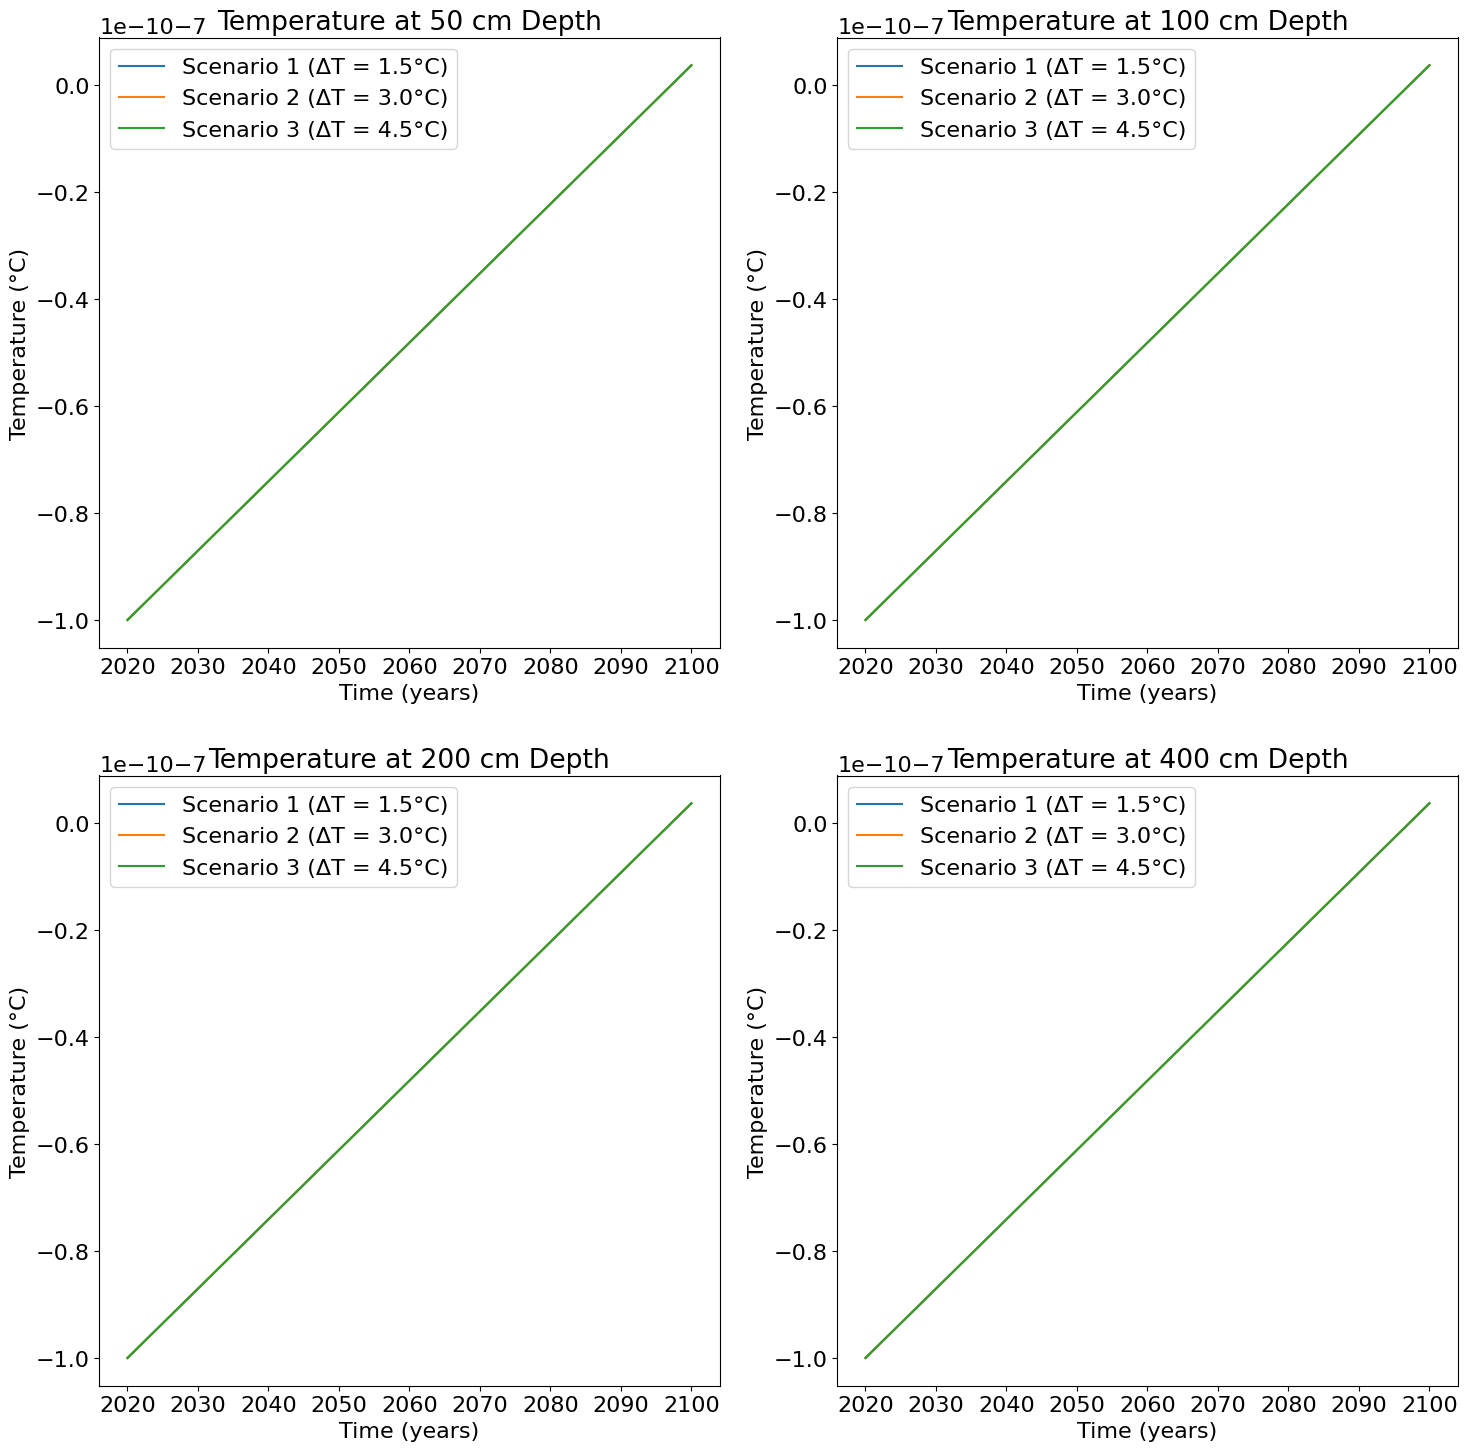

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Find indices for depths of interest
z_50_idx = np.argmin(np.abs(z - 50))
z_100_idx = np.argmin(np.abs(z - 100))
z_200_idx = np.argmin(np.abs(z - 200))
z_400_idx = np.argmin(np.abs(z - 400))


# Create a 2x2 subplot figure
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Plot temperature at 50 cm
axes[0, 0].plot(t, Ts[z_50_idx, :], label='Scenario 1 (ΔT = 1.5°C)')
axes[0, 0].plot(t, Ts[z_50_idx, :], label='Scenario 2 (ΔT = 3.0°C)')
axes[0, 0].plot(t, Ts[z_50_idx, :], label='Scenario 3 (ΔT = 4.5°C)')
axes[0, 0].set_xlabel('Time (years)')
axes[0, 0].set_ylabel('Temperature (°C)')
axes[0, 0].set_title('Temperature at 50 cm Depth')
axes[0, 0].legend()

# Plot temperature at 100 cm
axes[0, 1].plot(t, Ts[z_100_idx, :], label='Scenario 1 (ΔT = 1.5°C)')
axes[0, 1].plot(t, Ts[z_100_idx, :], label='Scenario 2 (ΔT = 3.0°C)')
axes[0, 1].plot(t, Ts[z_100_idx, :], label='Scenario 3 (ΔT = 4.5°C)')
axes[0, 1].set_xlabel('Time (years)')
axes[0, 1].set_ylabel('Temperature (°C)')
axes[0, 1].set_title('Temperature at 100 cm Depth')
axes[0, 1].legend()


# Plot temperature at 200 cm
axes[1, 0].plot(t, Ts[z_200_idx, :], label='Scenario 1 (ΔT = 1.5°C)')
axes[1, 0].plot(t, Ts[z_200_idx, :], label='Scenario 2 (ΔT = 3.0°C)')
axes[1, 0].plot(t, Ts[z_200_idx, :], label='Scenario 3 (ΔT = 4.5°C)')
axes[1, 0].set_xlabel('Time (years)')
axes[1, 0].set_ylabel('Temperature (°C)')
axes[1, 0].set_title('Temperature at 200 cm Depth')
axes[1, 0].legend()

# Plot temperature at 400 cm
axes[1, 1].plot(t, Ts[z_400_idx, :], label='Scenario 1 (ΔT = 1.5°C)')
axes[1, 1].plot(t, Ts[z_400_idx, :], label='Scenario 2 (ΔT = 3.0°C)')
axes[1, 1].plot(t, Ts[z_400_idx, :], label='Scenario 3 (ΔT = 4.5°C)')
axes[1, 1].set_xlabel('Time (years)')
axes[1, 1].set_ylabel('Temperature (°C)')
axes[1, 1].set_title('Temperature at 400 cm Depth')
axes[1, 1].legend()


plt.tight_layout()
plt.show()


In [19]:
import numpy as np
# Function to estimate active layer depth
def estimate_active_layer_depth(T_profile, z_values, threshold=0.0):
  """Estimates the active layer depth based on a temperature profile.

  Args:
    T_profile: A 1D array of temperatures at different depths.
    z_values: A 1D array of depths corresponding to the temperatures.
    threshold: The temperature threshold used to define the active layer.

  Returns:
    The approximate depth of the active layer in cm.
  """

  for i in range(len(T_profile) - 1):
    if T_profile[i] > threshold and T_profile[i+1] < threshold:
      return z_values[i]
  return z_values[-1]


# Decades of interest (first, middle, and final)
decades = [0, int(Nt / 2) - int(365 * 5), Nt - int(365 * 10)]

# Create a table
table_data = [
    ["Scenario", "First Decade", "Middle Decade", "Final Decade"],
    ["Scenario 1 (ΔT = 1.5°C)", "", "", ""],
    ["Scenario 2 (ΔT = 3.0°C)", "", "", ""],
    ["Scenario 3 (ΔT = 4.5°C)", "", "", ""]
]

# Loop through each scenario and decade
for scenario_index in range(3):
  for decade_index, decade_start in enumerate(decades):
    # Extract temperature profile for the current decade
    if decade_start + 365 * 10 < Nt:
      T_profile = np.mean(Ts[:, decade_start:decade_start + int(365 * 10)], axis=1)
    else:
      T_profile = np.mean(Ts[:, decade_start:], axis=1)
    active_layer_depth = estimate_active_layer_depth(T_profile, z)

    # Add the active layer depth to the table
    table_data[scenario_index + 1][decade_index + 1] = f"{active_layer_depth:.1f} cm"


# Print the table using Markdown
print("|", "|".join(table_data[0]), "|")
print("|---|---|---|---|")
for row in table_data[1:]:
    print("|", "|".join(row), "|")


| Scenario|First Decade|Middle Decade|Final Decade |
|---|---|---|---|
| Scenario 1 (ΔT = 1.5°C)|487.5 cm|487.5 cm|487.5 cm |
| Scenario 2 (ΔT = 3.0°C)|487.5 cm|487.5 cm|487.5 cm |
| Scenario 3 (ΔT = 4.5°C)|487.5 cm|487.5 cm|487.5 cm |
